In [1]:
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import os

Preliminaries: BassModel class, time range

In [269]:
class BassModel: 
    def __init__(self, m):
        # self.zoneid = zoneid
        self.m = m

    
    def c_t(self, x, p, q):
        num = 1 - (p + q)
        denom = 1 + (p + q)
        result = self.m * (
            ((1 - (num / denom) ** ((x + 1) / 2)) / (1 + q / p * (num / denom) ** ((x + 1) / 2))) -
            ((1 - (num / denom) ** ((x - 1) / 2)) / (1 + q / p * (num / denom) ** ((x - 1) / 2)))
        )
        return result


In [3]:
class LogisticModel:
    def __init__(self, a):
        self.a = a

    def c_t(self, x, b, c):
        return self.a / (1 + c * np.exp(-b * x))

In [4]:
class GompertzModel:
    def __init__(self, a):
        self.a = a

    def c_t(self, x, b, c):
        return self.a * np.exp(-c * np.exp(-b * x))

Next, we need to figure out how long we'd like to forecast over. For now, let's say we'd like to do 5 years, so we're going from 41 months (since Jan 2021 = March 2024) to 41 + 12 * 5

In [5]:
time_range = pd.Series(list(range(39, 39 + 12 * 5)))  # 5 years of monthly data starting from month 39
time_range

0     39
1     40
2     41
3     42
4     43
5     44
6     45
7     46
8     47
9     48
10    49
11    50
12    51
13    52
14    53
15    54
16    55
17    56
18    57
19    58
20    59
21    60
22    61
23    62
24    63
25    64
26    65
27    66
28    67
29    68
30    69
31    70
32    71
33    72
34    73
35    74
36    75
37    76
38    77
39    78
40    79
41    80
42    81
43    82
44    83
45    84
46    85
47    86
48    87
49    88
50    89
51    90
52    91
53    92
54    93
55    94
56    95
57    96
58    97
59    98
dtype: int64

In [6]:
time_range2 = pd.Series(list(range(0, 39)))  # 5 years of monthly data starting from month 0 to 39
time_range2

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
35    35
36    36
37    37
38    38
dtype: int64

Now the time ranges for the 2017 - 2020 generation model

In [7]:
bass_input_all_canada = pd.read_csv("bass_input_all_canada_new_with_tesla_b.csv")
length_months_01_2017_positive = len(bass_input_all_canada[bass_input_all_canada['yr_month_dtype'] >= '2017-01-01'])
time_range3 = pd.Series(list(range(0, length_months_01_2017_positive)))
time_range3

0      0
1      1
2      2
3      3
4      4
      ..
82    82
83    83
84    84
85    85
86    86
Length: 87, dtype: int64

In [8]:
time_range4 = pd.Series(list(range(length_months_01_2017_positive, length_months_01_2017_positive + 12 * 5)))  # 5 years of monthly data starting from month 0 to 39 + 5 years
time_range4

0      87
1      88
2      89
3      90
4      91
5      92
6      93
7      94
8      95
9      96
10     97
11     98
12     99
13    100
14    101
15    102
16    103
17    104
18    105
19    106
20    107
21    108
22    109
23    110
24    111
25    112
26    113
27    114
28    115
29    116
30    117
31    118
32    119
33    120
34    121
35    122
36    123
37    124
38    125
39    126
40    127
41    128
42    129
43    130
44    131
45    132
46    133
47    134
48    135
49    136
50    137
51    138
52    139
53    140
54    141
55    142
56    143
57    144
58    145
59    146
dtype: int64

In [9]:
time_range5 = pd.Series(list(range(0, 38 + 12 * 5)))  # 5 years of monthly data starting from month 0
time_range5

0      0
1      1
2      2
3      3
4      4
      ..
93    93
94    94
95    95
96    96
97    97
Length: 98, dtype: int64

In [10]:
time_range6 = pd.Series(list(range(0, 145)))  # 5 years of monthly data starting from month 0 to 39 + 5 years
time_range6 

0        0
1        1
2        2
3        3
4        4
      ... 
140    140
141    141
142    142
143    143
144    144
Length: 145, dtype: int64

In [11]:
original_data = pd.read_csv('canada_bev_data_train.csv')

In [12]:
original_data.loc[(original_data['VALUE'] > 0)|(original_data['months_since_start'] > 0)].head()

,REF_DATE,VALUE,BEV_Total_3M_Listings,months_since_start,ZoneID
0,2017-01,1664.0,212.0,0,Canada
1,2017-04,2197.0,355.0,3,Canada
2,2017-07,2401.0,451.0,6,Canada
3,2017-10,2824.0,439.0,9,Canada
4,2018-01,2639.0,510.0,12,Canada


In [ ]:
validation_data = pd.read_csv('canada_bev_data_val.csv')
validation_data

,REF_DATE,VALUE,BEV_Total_3M_Listings,months_since_start,ZoneID
0,2024-07,55883.0,NaN,90,Canada
1,2024-10,61363.0,NaN,93,Canada
2,2025-01,25731.0,NaN,96,Canada
3,2025-04,28852.0,NaN,99,Canada
4,2025-07,25803.0,NaN,102,Canada


### All Canada Simulation

All Canada Prediction - All Parameters Simulated

In [250]:
# input_folder_me_estimated_all_canada = '..\\bass_all_canada_m_estimated_05_06_26'
input_folder_me_estimated_all_canada = "..\\bass_all_canada_m_estimated_11_01_26"

In [251]:
params_all_canada_m_estimated_orig = pd.read_csv(f'.\\{input_folder_me_estimated_all_canada}\\all_canada_param_sims.csv')
# params_all_canada_m_estimated = pd.read_csv(f'.\\{input_folder_me_estimated_all_canada}\\all_canada_param_sims_05_01_26.csv')
params_all_canada_m_estimated_orig

,p,q,m
0,0.000148,0.037829,-1.153733e+06
1,0.000056,0.035847,4.533083e+06
2,-0.000262,0.024983,3.533272e+07
3,0.000108,0.033944,9.710058e+06
4,-0.000254,0.033843,1.072208e+07
...,...,...,...
995,0.000179,0.034887,6.946977e+06
996,-0.000096,0.027890,2.692741e+07
997,0.000536,0.042450,-1.476609e+07
998,0.000358,0.037441,-5.019071e+05


In [252]:
# Remove negative parameters
params_all_canada_m_estimated_orig = params_all_canada_m_estimated_orig[
    (params_all_canada_m_estimated_orig['p'] > 0) &
    (params_all_canada_m_estimated_orig['q'] > 0) &
    (params_all_canada_m_estimated_orig['m'] > 0)
]
params_all_canada_m_estimated_orig

,p,q,m
1,0.000056,0.035847,4.533083e+06
3,0.000108,0.033944,9.710058e+06
6,0.000061,0.031556,1.643180e+07
9,0.000197,0.037081,8.230394e+05
10,0.000228,0.026701,2.957139e+07
...,...,...,...
987,0.000187,0.029441,2.204835e+07
992,0.000062,0.031595,1.632267e+07
993,0.000095,0.035714,4.823544e+06
995,0.000179,0.034887,6.946977e+06


In [253]:
# params_all_canada_m_estimated['p'] = 5.9e-7   # Since it wasn't statistically different from zero

In [270]:
best_fit_params_m_estimated = pd.read_csv("..\\results_bass_all_canada_m_estimated_11_01_26.csv")
best_fit_params_m_estimated

,ZoneID,p,p_se,p_t,q,q_se,q_t,m,m_se,m_t,R2,RMSE
0,NaN,0.000145,0.000261,0.556857,0.034354,0.006322,5.434079,8.496100e+06,1.721722e+07,0.493465,0.945062,3045.66652


In [271]:
# Remove the rows with 2.5% largest and smallest values in the 'p' column
# params_all_canada_m_estimated = params_all_canada_m_estimated[(params_all_canada_m_estimated['p'] > params_all_canada_m_estimated['p'].quantile(0.2)) &   # Because p is zero, no need to filter
#                                                                  (params_all_canada_m_estimated['p'] < params_all_canada_m_estimated['p'].quantile(0.8))]
params_all_canada_m_estimated = params_all_canada_m_estimated_orig[(params_all_canada_m_estimated_orig['p'] > 0) &   # Because p is zero, no need to filter
                                                                 (params_all_canada_m_estimated_orig['p'] < params_all_canada_m_estimated_orig['p'].quantile(0.975))]
params_all_canada_m_estimated = params_all_canada_m_estimated[(params_all_canada_m_estimated['q'] > params_all_canada_m_estimated['q'].quantile(0.025)) &
                                                                (params_all_canada_m_estimated['q'] < params_all_canada_m_estimated['q'].quantile(0.975))].reset_index(drop=True)
params_all_canada_m_estimated = params_all_canada_m_estimated[(params_all_canada_m_estimated['m'] > params_all_canada_m_estimated['m'].quantile(0.025)) &
                                                                (params_all_canada_m_estimated['m'] < params_all_canada_m_estimated['m'].quantile(0.975))].reset_index(drop=True)

In [272]:
time_range_train = pd.Series(list(range(0, 88, 3)))
time_range_predict = pd.Series(list(range(90, 61 + 12 * 5, 3)))
time_range_all = pd.Series(list(range(0, 121, 3)))
time_range_train, time_range_predict

(0      0
 1      3
 2      6
 3      9
 4     12
 5     15
 6     18
 7     21
 8     24
 9     27
 10    30
 11    33
 12    36
 13    39
 14    42
 15    45
 16    48
 17    51
 18    54
 19    57
 20    60
 21    63
 22    66
 23    69
 24    72
 25    75
 26    78
 27    81
 28    84
 29    87
 dtype: int64,
 0      90
 1      93
 2      96
 3      99
 4     102
 5     105
 6     108
 7     111
 8     114
 9     117
 10    120
 dtype: int64)

In [273]:
output_all_canada_m_estimated = pd.DataFrame()
for i in range(len(params_all_canada_m_estimated)):
    market_size_all_canada_i = params_all_canada_m_estimated.loc[i, 'm']
    model = BassModel(market_size_all_canada_i)
    prediction_model = partial(model.c_t, p=params_all_canada_m_estimated.loc[i, 'p'], q=params_all_canada_m_estimated.loc[i, 'q'])
    predictions = time_range_predict.apply(prediction_model)
    output_all_canada_m_estimated = pd.concat([output_all_canada_m_estimated, predictions.rename(i)], axis=1)
output_all_canada_m_estimated.index = time_range_predict

In [274]:
params_all_canada_m_estimated.describe()

,p,q,m
count,367.000000,367.000000,3.670000e+02
mean,0.000168,0.033620,1.048831e+07
std,0.000108,0.002062,5.804125e+06
min,0.000001,0.029054,1.139538e+06
25%,0.000074,0.032045,5.485744e+06
50%,0.000156,0.033807,9.955040e+06
75%,0.000245,0.035388,1.486744e+07
max,0.000459,0.037006,2.336573e+07


In [275]:
model3 = BassModel(best_fit_params_m_estimated['m'][0])
prediction_model3 = partial(model3.c_t, p=best_fit_params_m_estimated['p'][0], q=best_fit_params_m_estimated['q'][0])
predictions3 = time_range_all.apply(prediction_model3)
predictions3.index = time_range_all
# output_all_canada_m_estimated = pd.concat([output_all_canada_m_estimated, predictions3.rename('best_fit')], axis=1)
output_all_canada_m_estimated_summarized = pd.concat([
    predictions3.rename('best_fit'),
    output_all_canada_m_estimated.max(axis=1).rename('max'),
    output_all_canada_m_estimated.min(axis=1).rename('min')
], axis=1)
output_all_canada_m_estimated_summarized

,best_fit,max,min
0,2467.321022,NaN,NaN
3,2733.967868,NaN,NaN
6,3029.129719,NaN,NaN
9,3355.786977,NaN,NaN
12,3717.215780,NaN,NaN
15,4117.013717,NaN,NaN
18,4559.126906,NaN,NaN
21,5047.878293,NaN,NaN
24,5587.996939,NaN,NaN
27,6184.647967,NaN,NaN


In [276]:
output_all_canada_m_estimated.max(axis=1), output_all_canada_m_estimated.min(axis=1)

(90     191043.433659
 93     201843.244472
 96     212668.895164
 99     223427.949972
 102    234019.104038
 105    244333.447544
 108    254256.161101
 111    263668.633812
 114    272450.969210
 117    280484.815848
 120    287656.430719
 dtype: float64,
 90      676.057111
 93      741.514207
 96      813.299951
 99      892.024389
 102     978.355998
 105    1073.027207
 108    1176.840430
 111    1290.674634
 114    1415.492519
 117    1552.348331
 120    1702.396382
 dtype: float64)

In [277]:

original_data_bass = original_data.loc[original_data['months_since_start'] >= 0, 'VALUE'].reset_index(drop=True)
original_data_bass

0      1664.0
1      2197.0
2      2401.0
3      2824.0
4      2639.0
5      7401.0
6      6558.0
7      5984.0
8      5282.0
9     12371.0
10    10139.0
11     7758.0
12     8021.0
13     6207.0
14    12855.0
15    11963.0
16    12760.0
17    16275.0
18    15851.0
19    14247.0
20    19636.0
21    21462.0
22    29146.0
23    27464.0
24    23799.0
25    34995.0
26    43250.0
27    39708.0
28    35510.0
29    48246.0
Name: VALUE, dtype: float64

In [278]:
output_all_canada_m_estimated

,0,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
90,11937.817917,39660.654717,32590.504864,159354.218939,65324.836968,26590.784232,2414.477996,34041.340737,91649.964048,101526.932015,...,87096.384424,17514.892207,78330.325836,19715.861307,48786.871394,100969.506282,33095.377404,20352.034762,47153.061303,25760.422423
93,13181.624572,43330.624197,35604.638114,168354.871243,70739.886866,29070.799154,2641.832868,36961.657366,98742.298566,108578.310532,...,93276.953881,19144.677283,84490.772126,21532.718588,52897.190664,108657.681360,36155.159928,22342.262864,51153.475466,28101.092588
96,14541.355308,47275.624345,38873.575123,177279.606375,76446.111707,31766.832875,2890.495481,40032.102080,106263.235948,115780.610726,...,99595.141034,20881.505429,90925.752352,23465.955756,57219.551382,116778.553238,39472.930440,24490.579710,55365.011611,30588.264989
99,16024.729951,51503.047344,42414.099431,186031.797009,82428.864632,34694.658815,3162.442914,43240.156240,114217.939247,123076.587400,...,105999.265176,22722.950543,97608.262316,25512.278447,61738.404332,125330.221811,43065.496640,26801.638499,59773.401876,33217.343101
102,17639.267259,56017.550266,46243.135645,194507.658662,88666.688776,37870.587890,3459.831763,46568.656038,122607.641070,130399.744902,...,112429.068755,24664.240334,104503.098265,27665.738344,66432.195934,134305.545567,46949.757569,29278.382187,64358.566164,35980.370084
105,19392.080129,60820.378870,50377.520820,202598.169153,95130.566078,41311.349555,3785.013662,49995.384236,131428.932807,137674.735679,...,118816.082231,26697.893251,111566.294356,29917.343783,71272.807566,143691.359004,51142.462958,31921.592276,69094.038579,38865.554130
108,21289.627557,65908.633458,54833.723710,210191.451258,101783.272012,45033.936716,4140.551991,53492.779818,140673.018526,144818.177011,...,125084.389418,28813.375839,118744.765551,32254.699024,76225.128216,153467.684590,55659.918904,34729.396470,73946.515844,41856.832975
111,23337.420080,71274.492212,59627.505971,217175.565500,108578.894081,49055.408935,4529.239829,57027.812054,150324.949379,151739.924949,...,131151.831638,30996.805280,125976.221700,34661.700175,81246.816841,163606.965219,60517.634002,37696.746612,78875.582740,44933.512070
114,25539.676848,76904.414828,64773.519830,223441.623822,115462.577487,53392.648088,4954.119197,60562.066414,160362.859429,158344.821117,...,136931.665794,33230.726369,133189.417870,37118.320357,86288.313211,174073.348903,65729.900615,40814.884079,83833.672695,48070.016235
117,27898.934526,82778.357496,70284.837620,228887.100022,122370.563483,58062.060587,5418.501654,64052.086509,170757.229178,164534.897772,...,142334.661267,35493.995506,140304.799587,39600.519756,91293.153932,184822.063128,71309.306903,44070.816302,88766.320507,51235.797967


In [279]:
# Number of months to cover
n_months = 120

# Base date: January 2017
base_date = pd.Timestamp("2017-01-01")

# Create a synthetic "time index" analogous to time_range_log3
time_range_log_cov = np.arange(n_months)

# No backward shift needed since we start exactly at base_date
month_shift = 0

# Convert each t to a calendar date using DateOffset (NOT timedelta)
raw_dates = pd.DatetimeIndex([
    base_date + pd.DateOffset(months=int(t - month_shift))
    for t in time_range_log_cov
])

# Round to nearest 6-month period (semiannual)
data_coverage = (
    raw_dates
    .to_period("6M")
    .to_timestamp(how="start")   # Jan 1 / Jul 1 anchors
)

In [280]:
original_data_bass

0      1664.0
1      2197.0
2      2401.0
3      2824.0
4      2639.0
5      7401.0
6      6558.0
7      5984.0
8      5282.0
9     12371.0
10    10139.0
11     7758.0
12     8021.0
13     6207.0
14    12855.0
15    11963.0
16    12760.0
17    16275.0
18    15851.0
19    14247.0
20    19636.0
21    21462.0
22    29146.0
23    27464.0
24    23799.0
25    34995.0
26    43250.0
27    39708.0
28    35510.0
29    48246.0
Name: VALUE, dtype: float64

The size of the confidence interval depends on the number of valid values of p

In [281]:
output_all_canada_m_estimated.shape[1] / params_all_canada_m_estimated_orig.shape[0]

0.8738095238095238

Adding line showing post-March 2024 sales

In [282]:
original_data_bass_plot = original_data_bass.rename('Actual EV Sales')
original_data_bass_plot.index = time_range_train

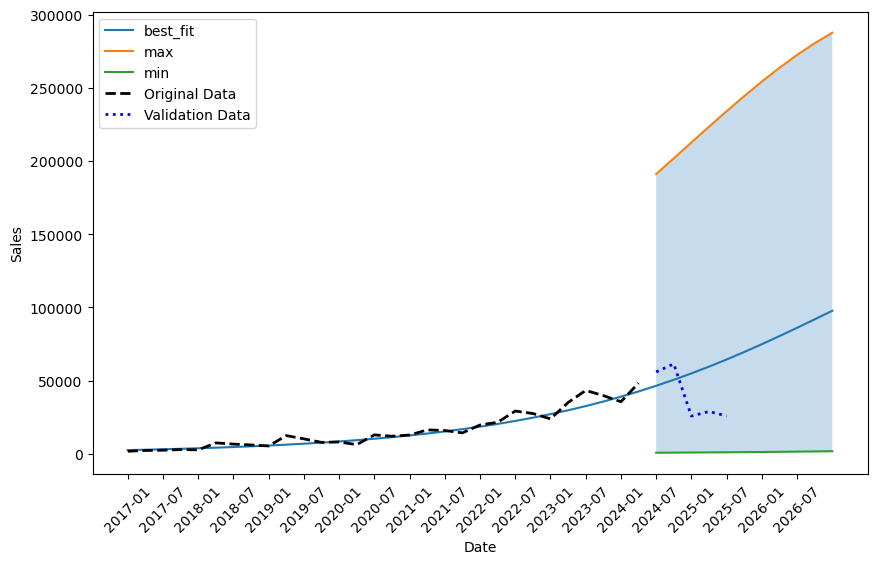

In [283]:
# Plot summarized predictions (e.g. mean/central estimate if present)
output_all_canada_m_estimated_summarized.plot(
    legend=False,
    # title='All Canada Predictions with Estimated m',
    figsize=(10, 6)
)

# Shade area between min and max
plt.fill_between(
    output_all_canada_m_estimated_summarized.index,
    output_all_canada_m_estimated_summarized['min'],
    output_all_canada_m_estimated_summarized['max'],
    alpha=0.25
)

# Plot original data
plt.plot(
    original_data_bass_plot,
    label='Original Data',
    color='black',
    linewidth=2,
    linestyle='--'
)


# Only tick every 6th month
tick_positions = np.arange(0, len(data_coverage), 6)
tick_labels = data_coverage.strftime('%Y-%m')[::6]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

# Plot validation data
plt.plot(
    validation_data['months_since_start'],
    validation_data['VALUE'],
    label='Validation Data',
    color='blue',
    linewidth=2,
    linestyle=':'
)

plt.xlabel('Date')
plt.ylabel('Sales')

# Legend
plt.legend()

plt.show()


In [292]:

# --- Correct RMSE calculations (train & validation) ---

# Make predictions positional to align by count (0..N-1)
yhat_all = predictions3.reset_index(drop=True)

# TRAIN RMSE
len_train = len(original_data_bass_plot)
ytrue_train = original_data_bass_plot.reset_index(drop=True).astype(float).to_numpy()
yhat_train  = yhat_all.iloc[:len_train].astype(float).to_numpy()

assert yhat_train.shape == ytrue_train.shape, \
    f"Train shapes don't match: preds {yhat_train.shape}, truth {ytrue_train.shape}"

rmse_train = float(np.sqrt(np.mean((yhat_train - ytrue_train) ** 2)))
print("Train RMSE:", rmse_train)

# VALIDATION RMSE
len_val = len(validation_data)
ytrue_val = validation_data['VALUE'].reset_index(drop=True).astype(float).to_numpy()
yhat_val  = yhat_all.iloc[len_train : len_train + len_val].astype(float).to_numpy()

assert yhat_val.shape == ytrue_val.shape, \
    f"Val shapes don't match: preds {yhat_val.shape}, truth {ytrue_val.shape}"

rmse_val = float(np.sqrt(np.mean((yhat_val - ytrue_val) ** 2)))
print("Validation RMSE:", rmse_val)


Train RMSE: 3503.19255696466
Validation RMSE: 26402.592527361165


The RMSEs for the train dataset are different just because of axis misalignment. 

In [212]:
ytrue_train

array([ 1664.,  2197.,  2401.,  2824.,  2639.,  7401.,  6558.,  5984.,
        5282., 12371., 10139.,  7758.,  8021.,  6207., 12855., 11963.,
       12760., 16275., 15851., 14247., 19636., 21462., 29146., 27464.,
       23799., 34995., 43250., 39708., 35510., 48246.])

In [213]:
yhat_train

array([ 2467.32177516,  2733.96863677,  3029.13049973,  3355.78776347,
        3717.21656651,  4117.01449586,  4559.12766808,  5047.8790284 ,
        5587.99763678,  6184.64861339,  6843.46329658,  7570.5690202 ,
        8372.61774051,  9256.81253017, 10230.93070469, 11303.3420504 ,
       12483.0202786 , 13779.54543665, 15203.09456219, 16764.41737525,
       18474.79327147, 20345.96532266, 22390.04642963, 24619.39224097,
       27046.43499594, 29683.47213302, 32542.40341051, 35634.41051362,
       38969.57379835, 42556.42208867])

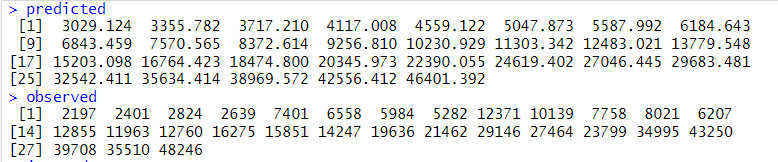

The shape of the curve messing with logistic and gompertz models

Looking at previous generation (2017 - 2020 EVs)

In [26]:
original_data.columns

Index(['REF_DATE', 'VALUE', 'BEV_Total_3M_Listings', 'months_since_start',
       'ZoneID'],
      dtype='object')

In [27]:
models_17_20 = original_data.loc[original_data['months_passed_01_2017'] >= 0, '2017-2020_Total_EV_Sales'].reset_index(drop=True)

KeyError: 'months_passed_01_2017'

In [33]:
input_folder_me_estimated_all_canada_prev_gen = 'bass_all_canada_m_estimated_07_06_26_older_vehicles'

In [34]:
best_fit_params_m_estimated_prev_gen = pd.read_csv("../results_bass_all_canada_m_estimated_07_06_26_older_vehicles.csv")
best_fit_params_m_estimated_prev_gen

,ZoneID,p,p_se,p_t,q,q_se,q_t,m,m_se,m_t,R2,RMSE
0,NaN,0.000059,0.000034,1.757881,0.089982,0.008799,10.225881,16245.343393,1280.075479,12.690926,0.649277,344.421282


In [35]:
params_all_canada_m_estimated_prev_gen = pd.read_csv(f'..\\{input_folder_me_estimated_all_canada_prev_gen}\\all_canada_param_sims.csv')
params_all_canada_m_estimated_prev_gen

,p,q,m
0,0.000069,0.086076,15527.892261
1,0.000083,0.083989,15950.698833
2,0.000086,0.081457,18240.607685
3,0.000074,0.088683,16335.599456
4,0.000129,0.071552,16410.841453
...,...,...,...
995,0.000064,0.091000,16130.168350
996,0.000070,0.085988,17615.684722
997,0.000021,0.099193,14515.832920
998,0.000045,0.096533,15576.354574


In [36]:
# Remove negative values
params_all_canada_m_estimated_prev_gen = params_all_canada_m_estimated_prev_gen[(params_all_canada_m_estimated_prev_gen['p'] > 0) &   # Because p is zero, no need to filter
                                                                                                 (params_all_canada_m_estimated_prev_gen['p'] < params_all_canada_m_estimated_prev_gen['p'].quantile(0.975))]
params_all_canada_m_estimated_prev_gen.describe()

,p,q,m
count,9.340000e+02,934.000000,934.000000
mean,5.932360e-05,0.089911,16292.227575
std,2.695239e-05,0.007200,1220.632149
min,5.401202e-07,0.069547,12648.619725
25%,3.977812e-05,0.085094,15502.685157
50%,5.782237e-05,0.090051,16282.226355
75%,7.859938e-05,0.095586,17094.401531
max,1.206601e-04,0.105956,19542.113483


In [37]:
# Remove the rows with 2.5% largest and smallest values in the 'p' column
params_all_canada_m_estimated_prev_gen = params_all_canada_m_estimated_prev_gen[(params_all_canada_m_estimated_prev_gen['p'] > params_all_canada_m_estimated_prev_gen['p'].quantile(0.025)) &
                                                                (params_all_canada_m_estimated_prev_gen['p'] < params_all_canada_m_estimated_prev_gen['p'].quantile(0.975))]
params_all_canada_m_estimated_prev_gen = params_all_canada_m_estimated_prev_gen[(params_all_canada_m_estimated_prev_gen['q'] > params_all_canada_m_estimated_prev_gen['q'].quantile(0.025)) &
                                                                (params_all_canada_m_estimated_prev_gen['q'] < params_all_canada_m_estimated_prev_gen['q'].quantile(0.975))].reset_index(drop=True)
params_all_canada_m_estimated_prev_gen = params_all_canada_m_estimated_prev_gen[(params_all_canada_m_estimated_prev_gen['m'] > params_all_canada_m_estimated_prev_gen['m'].quantile(0.025)) &
                                                                (params_all_canada_m_estimated_prev_gen['m'] < params_all_canada_m_estimated_prev_gen['m'].quantile(0.975))].reset_index(drop=True)

In [38]:
output_all_canada_m_estimated_prev_gen = pd.DataFrame()
for i in range(len(params_all_canada_m_estimated_prev_gen)):
    market_size_all_canada_i = params_all_canada_m_estimated_prev_gen.loc[i, 'm']
    model = BassModel(market_size_all_canada_i)
    prediction_model = partial(model.c_t, p=params_all_canada_m_estimated_prev_gen.loc[i, 'p'], q=params_all_canada_m_estimated_prev_gen.loc[i, 'q'])
    predictions = time_range4.apply(prediction_model)
    output_all_canada_m_estimated_prev_gen = pd.concat([output_all_canada_m_estimated_prev_gen, predictions.rename(i)], axis=1)
output_all_canada_m_estimated_prev_gen.index = time_range4

In [39]:
output_all_canada_m_estimated_prev_gen

,0,1,2,3,4,5,6,7,8,9,...,788,789,790,791,792,793,794,795,796,797
87,0.995550,1.166869,1.887016,0.660510,1.000997,0.987779,0.230309,0.751226,2.004284,0.483094,...,0.440459,0.631715,0.800518,0.956290,2.200561,0.528963,1.130861,0.403637,0.313775,0.711966
88,0.837680,0.985950,1.602625,0.552839,0.839046,0.825898,0.189011,0.628044,1.709444,0.401135,...,0.364784,0.525400,0.669286,0.804745,1.876737,0.440677,0.951700,0.330781,0.258510,0.596585
89,0.704838,0.833073,1.361074,0.462717,0.703291,0.690540,0.155118,0.525056,1.457953,0.333078,...,0.302110,0.436974,0.559563,0.677210,1.600537,0.367125,0.800916,0.271074,0.212978,0.499900
90,0.593057,0.703894,1.155916,0.387285,0.589497,0.577362,0.127302,0.438954,1.243443,0.276567,...,0.250203,0.363429,0.467826,0.569883,1.364964,0.305848,0.674016,0.222144,0.175466,0.418881
91,0.499001,0.594742,0.981672,0.324148,0.494112,0.482731,0.104474,0.366970,1.060482,0.229643,...,0.207214,0.302261,0.391126,0.479562,1.164049,0.254798,0.567219,0.182045,0.144560,0.350991
92,0.419859,0.502512,0.833686,0.271303,0.414159,0.403608,0.085740,0.306789,0.904433,0.190680,...,0.171610,0.251388,0.327000,0.403554,0.992695,0.212268,0.477341,0.149184,0.119097,0.294104
93,0.353268,0.424583,0.708003,0.227072,0.347142,0.337452,0.070365,0.256476,0.771339,0.158328,...,0.142124,0.209076,0.273386,0.339591,0.846558,0.176837,0.401703,0.122255,0.098120,0.246436
94,0.297237,0.358737,0.601264,0.190052,0.290968,0.282139,0.057747,0.214414,0.657826,0.131464,...,0.117704,0.173886,0.228562,0.285765,0.721928,0.147319,0.338048,0.100186,0.080837,0.206493
95,0.250092,0.303102,0.510615,0.159067,0.243884,0.235892,0.047391,0.179250,0.561015,0.109158,...,0.097479,0.144618,0.191087,0.240470,0.615642,0.122729,0.284480,0.082101,0.066598,0.173024
96,0.210424,0.256094,0.433630,0.133134,0.204418,0.197225,0.038893,0.149852,0.478449,0.090637,...,0.080730,0.120276,0.159756,0.202354,0.525001,0.102243,0.239400,0.067281,0.054868,0.144979


In [40]:
model4 = BassModel(best_fit_params_m_estimated_prev_gen['m'][0])
prediction_model4 = partial(model4.c_t, p=best_fit_params_m_estimated_prev_gen['p'][0], q=best_fit_params_m_estimated_prev_gen['q'][0])
predictions4 = time_range6.apply(prediction_model4)
output_all_canada_m_estimated_prev_gen = pd.concat([output_all_canada_m_estimated_prev_gen, predictions4.rename('best_fit')], axis=1)


In [41]:
# Series of 100 months starting '01-2021'
data_coverage2 = pd.date_range(start='2017-01-01', periods=len(output_all_canada_m_estimated_prev_gen), freq='M')
data_coverage2

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_16208\2005365837.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data_coverage2 = pd.date_range(start='2017-01-01', periods=len(output_all_canada_m_estimated_prev_gen), freq='M')


DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31',
               ...
               '2028-06-30', '2028-07-31', '2028-08-31', '2028-09-30',
               '2028-10-31', '2028-11-30', '2028-12-31', '2029-01-31',
               '2029-02-28', '2029-03-31'],
              dtype='datetime64[ns]', length=147, freq='ME')

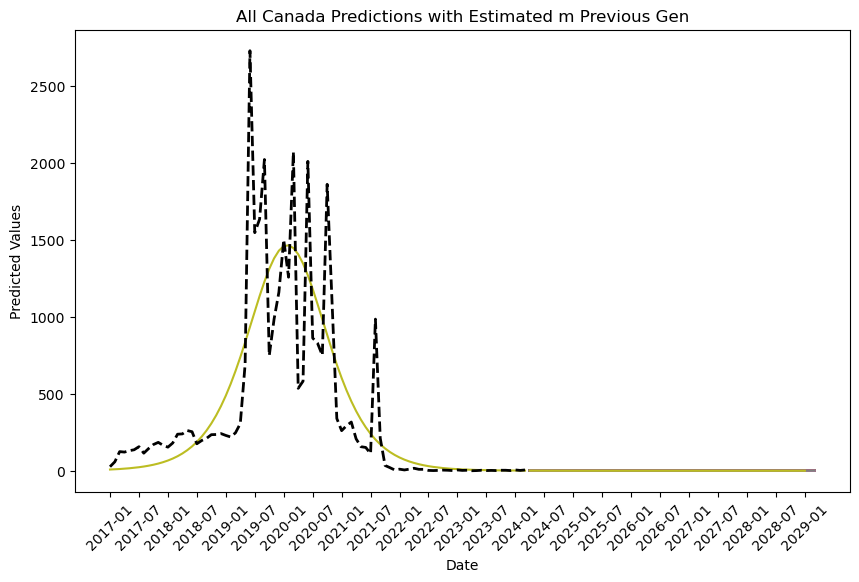

In [42]:
output_all_canada_m_estimated_prev_gen.plot(legend=False, title='All Canada Predictions with Estimated m Previous Gen', figsize=(10, 6))
# Plot original data
plt.plot(models_17_20, label='Original Data', color='black', linewidth=2, linestyle='--')
# only tick every 6th month
tick_positions = np.arange(0, len(data_coverage2), 6)
tick_labels    = data_coverage2.strftime('%Y-%m')[::6]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.show()

# Logistic Model

In [28]:
original_data_log_gomp = pd.read_csv('canada_bev_data_train.csv')

In [29]:
params_logistic = pd.read_csv('..\\logistic_all_canada_m_estimated_10_01_26\\all_canada_param_sims_logistic.csv')
params_logistic

,a,b,c
0,1.250268e+06,0.046249,90.482075
1,1.320884e+06,0.045779,93.306352
2,1.703342e+06,0.043440,114.156892
3,1.385170e+06,0.045941,100.052574
4,1.397737e+06,0.044313,89.943924
...,...,...,...
995,1.350859e+06,0.046302,99.505532
996,1.598968e+06,0.044389,110.898073
997,1.081235e+06,0.048267,88.863895
998,1.258362e+06,0.047277,97.578314


In [30]:
best_fit_params_logistic = pd.read_csv('..\\results_log_all_canada_m_estimated_10_01_26.csv')
best_fit_params_logistic

,ZoneID,a,a_se,a_t,b,b_se,b_t,c,c_se,c_t,R2,RMSE
0,NaN,1.370095e+06,213796.711281,6.408403,0.045996,0.001703,27.005878,99.990299,10.145329,9.855797,0.936129,3283.982908


In [31]:
original_data_values = original_data_log_gomp['VALUE']

In [32]:
original_data_values_cumsum = original_data_values.cumsum()

In [33]:
# Remove the rows with 2.5% largest and smallest values in the 'b' column
params_logistic = params_logistic[(params_logistic['b'] > params_logistic['b'].quantile(0.025)) &
                                  (params_logistic['b'] < params_logistic['b'].quantile(0.975))]
params_logistic = params_logistic[(params_logistic['c'] > params_logistic['c'].quantile(0.025)) &
                                  (params_logistic['c'] < params_logistic['c'].quantile(0.975))].reset_index(drop=True)
params_logistic = params_logistic[(params_logistic['a'] > params_logistic['a'].quantile(0.025)) &
                                  (params_logistic['a'] < params_logistic['a'].quantile(0.975))].reset_index(drop=True)

In [34]:
time_range_log2_orig = original_data_log_gomp.loc[(original_data_log_gomp['months_since_start'] >= 0)|(original_data_log_gomp['VALUE'] > 0), 'months_since_start'].reset_index(drop=True)
time_range_log2 = time_range_log2_orig + np.abs(time_range_log2_orig.min())
time_range_log2

0      0
1      3
2      6
3      9
4     12
5     15
6     18
7     21
8     24
9     27
10    30
11    33
12    36
13    39
14    42
15    45
16    48
17    51
18    54
19    57
20    60
21    63
22    66
23    69
24    72
25    75
26    78
27    81
28    84
29    87
Name: months_since_start, dtype: int64

In [35]:
time_range_log = pd.Series(list(range(90, 61 + 12 * 5, 3)))    # +9 for the months in 2020 with sales
time_range_log

0      90
1      93
2      96
3      99
4     102
5     105
6     108
7     111
8     114
9     117
10    120
dtype: int64

In [36]:
time_range_log3 = pd.concat([time_range_log2, time_range_log]).reset_index(drop=True)
time_range_log3

0       0
1       3
2       6
3       9
4      12
5      15
6      18
7      21
8      24
9      27
10     30
11     33
12     36
13     39
14     42
15     45
16     48
17     51
18     54
19     57
20     60
21     63
22     66
23     69
24     72
25     75
26     78
27     81
28     84
29     87
30     90
31     93
32     96
33     99
34    102
35    105
36    108
37    111
38    114
39    117
40    120
dtype: int64

In [37]:
output_all_canada_logistic = pd.DataFrame()
for i in range(len(params_logistic)):
    model = LogisticModel(params_logistic.loc[i, 'a'])
    prediction_model = partial(model.c_t, b=params_logistic.loc[i, 'b'], c=params_logistic.loc[i, 'c'])
    predictions = time_range_log.apply(prediction_model)
    output_all_canada_logistic = pd.concat([output_all_canada_logistic, predictions.rename(i)], axis=1)
output_all_canada_logistic.index = time_range_log



In [38]:
# Inverse of cumsum on output_all_canada_logistic
output_all_canada_logistic = output_all_canada_logistic.diff()
output_all_canada_logistic = output_all_canada_logistic.dropna(axis=0, how='all')
output_all_canada_logistic

,0,1,2,3,4,5,6,7,8,9,...,846,847,848,849,850,851,852,853,854,855
93,42551.603071,43997.312359,45833.405104,44218.295421,46556.418003,43303.870048,43355.804059,48796.949167,45868.581372,46281.099362,...,46803.197156,40805.893731,46845.200485,44230.480184,45334.406774,45377.977375,48015.989031,39074.782818,43884.272461,44390.019425
96,43154.950703,44839.741647,46886.335205,45328.587748,47980.530173,43719.602545,44048.415084,50059.936097,47192.468002,47374.214457,...,48310.950610,41044.452967,48236.233437,45088.342673,46618.165889,46306.161015,49853.058209,39070.007130,44457.805774,45200.688126
99,43350.303018,45274.813991,47518.682997,46068.365319,49012.542505,43690.693536,44324.493332,50856.149561,48134.897399,48039.281159,...,49445.503919,40859.349611,49226.757266,45534.411476,47523.946733,46806.150910,51332.890436,38659.263855,44590.463140,45590.820228
102,43130.227978,45286.402117,47707.002911,46412.298094,49616.238246,43218.314967,44173.490500,51154.642034,48663.398448,48251.413761,...,50168.710556,40258.166582,49781.651459,45552.054944,48020.531631,46859.021184,52407.223842,37859.449208,44276.968565,45545.655753
105,42503.094624,44874.073307,47444.222057,46348.400751,49769.894248,42321.453688,43601.188186,50943.623660,48759.339699,48002.565713,...,50455.556987,39265.180926,49880.772727,45140.610231,48090.423032,46462.752872,53039.672629,36702.701877,43529.752649,45066.913079
108,41492.404539,44053.123371,46740.198456,45878.910009,49467.918098,41035.312994,42629.232747,50231.439859,48419.306375,47302.170897,...,50295.971699,37919.315761,49520.487437,44315.435646,47731.136504,45632.395970,53208.286664,35233.720154,42377.918286,44172.651510
111,40134.951020,42853.386310,45620.944190,45020.119916,48721.276053,39408.442274,41293.422016,49045.878152,47655.356011,46176.392359,...,49695.568455,36270.986698,48713.951688,43106.708012,46955.386490,44398.870215,52907.147612,33506.226194,40864.876593,42895.843440
114,38478.048501,41316.976079,44126.616964,43801.195629,47556.656376,37498.985894,39640.972243,47431.901494,46494.120302,44666.079626,...,48675.230973,34378.267426,47490.102511,41557.124019,45790.141328,42806.565924,52146.805831,31579.037241,39044.975346,41281.846521
117,36576.179330,39495.246951,42308.540878,42262.111509,46014.476004,35370.527719,37727.113223,45448.119147,44974.866291,42823.702875,...,47269.591039,32302.849170,45891.490922,39718.799072,44274.666257,40910.057056,50953.503457,29512.202169,36979.553737,39385.100070
120,34487.445411,37445.335069,40225.624009,40450.957770,44145.980945,33088.005047,35611.413661,43162.456215,43146.754157,40709.646758,...,45524.587112,30106.234348,43971.229418,37649.735875,42457.793015,38770.329045,49367.280453,27363.585735,34732.886888,37265.442047


<Axes: title={'center': 'All Canada Logistic Predictions'}>

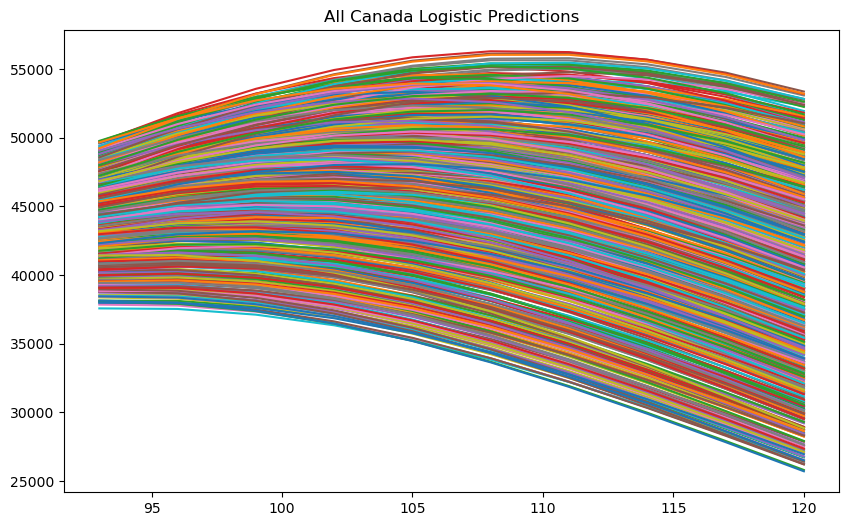

In [39]:
output_all_canada_logistic.plot(legend=False, title='All Canada Logistic Predictions', figsize=(10, 6))

In [40]:
output_all_canada_logistic_summarized = pd.concat([
    output_all_canada_logistic.max(axis=1).rename('max'),
    output_all_canada_logistic.min(axis=1).rename('min'),
], axis=1)

In [41]:
output_all_canada_logistic

,0,1,2,3,4,5,6,7,8,9,...,846,847,848,849,850,851,852,853,854,855
93,42551.603071,43997.312359,45833.405104,44218.295421,46556.418003,43303.870048,43355.804059,48796.949167,45868.581372,46281.099362,...,46803.197156,40805.893731,46845.200485,44230.480184,45334.406774,45377.977375,48015.989031,39074.782818,43884.272461,44390.019425
96,43154.950703,44839.741647,46886.335205,45328.587748,47980.530173,43719.602545,44048.415084,50059.936097,47192.468002,47374.214457,...,48310.950610,41044.452967,48236.233437,45088.342673,46618.165889,46306.161015,49853.058209,39070.007130,44457.805774,45200.688126
99,43350.303018,45274.813991,47518.682997,46068.365319,49012.542505,43690.693536,44324.493332,50856.149561,48134.897399,48039.281159,...,49445.503919,40859.349611,49226.757266,45534.411476,47523.946733,46806.150910,51332.890436,38659.263855,44590.463140,45590.820228
102,43130.227978,45286.402117,47707.002911,46412.298094,49616.238246,43218.314967,44173.490500,51154.642034,48663.398448,48251.413761,...,50168.710556,40258.166582,49781.651459,45552.054944,48020.531631,46859.021184,52407.223842,37859.449208,44276.968565,45545.655753
105,42503.094624,44874.073307,47444.222057,46348.400751,49769.894248,42321.453688,43601.188186,50943.623660,48759.339699,48002.565713,...,50455.556987,39265.180926,49880.772727,45140.610231,48090.423032,46462.752872,53039.672629,36702.701877,43529.752649,45066.913079
108,41492.404539,44053.123371,46740.198456,45878.910009,49467.918098,41035.312994,42629.232747,50231.439859,48419.306375,47302.170897,...,50295.971699,37919.315761,49520.487437,44315.435646,47731.136504,45632.395970,53208.286664,35233.720154,42377.918286,44172.651510
111,40134.951020,42853.386310,45620.944190,45020.119916,48721.276053,39408.442274,41293.422016,49045.878152,47655.356011,46176.392359,...,49695.568455,36270.986698,48713.951688,43106.708012,46955.386490,44398.870215,52907.147612,33506.226194,40864.876593,42895.843440
114,38478.048501,41316.976079,44126.616964,43801.195629,47556.656376,37498.985894,39640.972243,47431.901494,46494.120302,44666.079626,...,48675.230973,34378.267426,47490.102511,41557.124019,45790.141328,42806.565924,52146.805831,31579.037241,39044.975346,41281.846521
117,36576.179330,39495.246951,42308.540878,42262.111509,46014.476004,35370.527719,37727.113223,45448.119147,44974.866291,42823.702875,...,47269.591039,32302.849170,45891.490922,39718.799072,44274.666257,40910.057056,50953.503457,29512.202169,36979.553737,39385.100070
120,34487.445411,37445.335069,40225.624009,40450.957770,44145.980945,33088.005047,35611.413661,43162.456215,43146.754157,40709.646758,...,45524.587112,30106.234348,43971.229418,37649.735875,42457.793015,38770.329045,49367.280453,27363.585735,34732.886888,37265.442047


In [42]:

original_data_values_log = original_data.loc[(original_data['months_since_start'] >= 0)|(original_data['VALUE'] > 0), 'VALUE'].reset_index(drop=True)
original_data_values_log

0      1664.0
1      2197.0
2      2401.0
3      2824.0
4      2639.0
5      7401.0
6      6558.0
7      5984.0
8      5282.0
9     12371.0
10    10139.0
11     7758.0
12     8021.0
13     6207.0
14    12855.0
15    11963.0
16    12760.0
17    16275.0
18    15851.0
19    14247.0
20    19636.0
21    21462.0
22    29146.0
23    27464.0
24    23799.0
25    34995.0
26    43250.0
27    39708.0
28    35510.0
29    48246.0
Name: VALUE, dtype: float64

In [43]:
original_data_values_log.index = time_range_log2.reset_index(drop=True)

In [44]:
best_fit_params_logistic['a'][0], best_fit_params_logistic['b'][0], best_fit_params_logistic['c'][0]

(1370095.4477482906, 0.0459962967986487, 99.99029888691096)

In [45]:
# Number of months to cover
n_months = 120

# Base date: January 2017
base_date = pd.Timestamp("2017-01-01")

# Create a synthetic "time index" analogous to time_range_log3
time_range_log_cov = np.arange(n_months)

# No backward shift needed since we start exactly at base_date
month_shift = 0

# Convert each t to a calendar date using DateOffset (NOT timedelta)
raw_dates = pd.DatetimeIndex([
    base_date + pd.DateOffset(months=int(t - month_shift))
    for t in time_range_log_cov
])

# Round to nearest 6-month period (semiannual)
data_coverage_log = (
    raw_dates
    .to_period("6M")
    .to_timestamp(how="start")   # Jan 1 / Jul 1 anchors
)

In [46]:
output_all_canada_logistic

,0,1,2,3,4,5,6,7,8,9,...,846,847,848,849,850,851,852,853,854,855
93,42551.603071,43997.312359,45833.405104,44218.295421,46556.418003,43303.870048,43355.804059,48796.949167,45868.581372,46281.099362,...,46803.197156,40805.893731,46845.200485,44230.480184,45334.406774,45377.977375,48015.989031,39074.782818,43884.272461,44390.019425
96,43154.950703,44839.741647,46886.335205,45328.587748,47980.530173,43719.602545,44048.415084,50059.936097,47192.468002,47374.214457,...,48310.950610,41044.452967,48236.233437,45088.342673,46618.165889,46306.161015,49853.058209,39070.007130,44457.805774,45200.688126
99,43350.303018,45274.813991,47518.682997,46068.365319,49012.542505,43690.693536,44324.493332,50856.149561,48134.897399,48039.281159,...,49445.503919,40859.349611,49226.757266,45534.411476,47523.946733,46806.150910,51332.890436,38659.263855,44590.463140,45590.820228
102,43130.227978,45286.402117,47707.002911,46412.298094,49616.238246,43218.314967,44173.490500,51154.642034,48663.398448,48251.413761,...,50168.710556,40258.166582,49781.651459,45552.054944,48020.531631,46859.021184,52407.223842,37859.449208,44276.968565,45545.655753
105,42503.094624,44874.073307,47444.222057,46348.400751,49769.894248,42321.453688,43601.188186,50943.623660,48759.339699,48002.565713,...,50455.556987,39265.180926,49880.772727,45140.610231,48090.423032,46462.752872,53039.672629,36702.701877,43529.752649,45066.913079
108,41492.404539,44053.123371,46740.198456,45878.910009,49467.918098,41035.312994,42629.232747,50231.439859,48419.306375,47302.170897,...,50295.971699,37919.315761,49520.487437,44315.435646,47731.136504,45632.395970,53208.286664,35233.720154,42377.918286,44172.651510
111,40134.951020,42853.386310,45620.944190,45020.119916,48721.276053,39408.442274,41293.422016,49045.878152,47655.356011,46176.392359,...,49695.568455,36270.986698,48713.951688,43106.708012,46955.386490,44398.870215,52907.147612,33506.226194,40864.876593,42895.843440
114,38478.048501,41316.976079,44126.616964,43801.195629,47556.656376,37498.985894,39640.972243,47431.901494,46494.120302,44666.079626,...,48675.230973,34378.267426,47490.102511,41557.124019,45790.141328,42806.565924,52146.805831,31579.037241,39044.975346,41281.846521
117,36576.179330,39495.246951,42308.540878,42262.111509,46014.476004,35370.527719,37727.113223,45448.119147,44974.866291,42823.702875,...,47269.591039,32302.849170,45891.490922,39718.799072,44274.666257,40910.057056,50953.503457,29512.202169,36979.553737,39385.100070
120,34487.445411,37445.335069,40225.624009,40450.957770,44145.980945,33088.005047,35611.413661,43162.456215,43146.754157,40709.646758,...,45524.587112,30106.234348,43971.229418,37649.735875,42457.793015,38770.329045,49367.280453,27363.585735,34732.886888,37265.442047


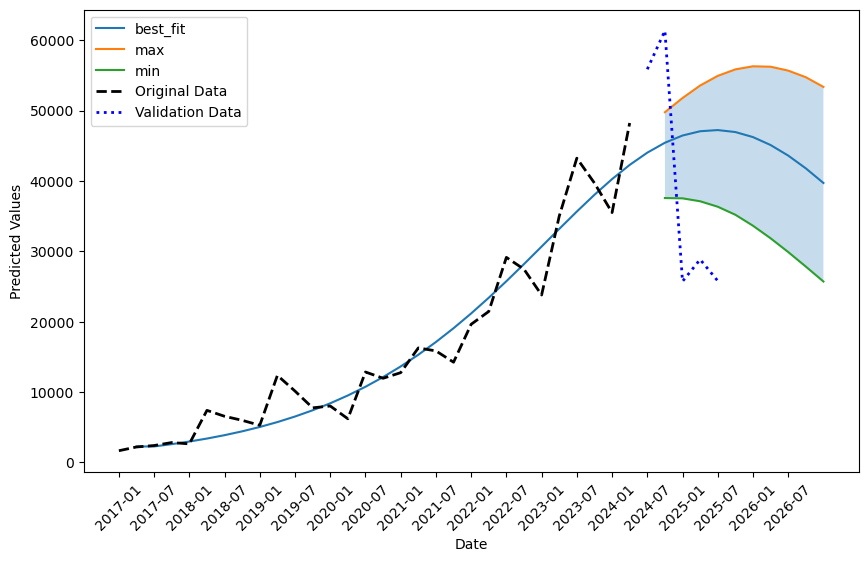

In [48]:
model_logistic = LogisticModel(best_fit_params_logistic['a'][0])
prediction_model_logistic = partial(model_logistic.c_t, b=best_fit_params_logistic['b'][0], c=best_fit_params_logistic['c'][0])
predictions_logistic = time_range_log3.apply(prediction_model_logistic)
predictions_logistic = predictions_logistic.diff().dropna()
predictions_logistic.iloc[0] = predictions_logistic.iloc[1]   # Get rid of weirdly high first value
predictions_logistic.index = time_range_log3.drop(0).reset_index(drop=True)

output_all_canada_logistic_plot = pd.concat([predictions_logistic.rename('best_fit'), output_all_canada_logistic_summarized], axis=1)
# output_all_canada_logistic.index = time_range2
output_all_canada_logistic_plot.plot(legend=False, figsize=(10, 6))

plt.fill_between(
    output_all_canada_logistic_plot.index,
    output_all_canada_logistic_plot['min'],
    output_all_canada_logistic_plot['max'],
    alpha=0.25
)

# Plot original data
plt.plot(original_data_values_log, label='Original Data', color='black', linewidth=2, linestyle='--')
# only tick every 6th month
tick_positions = np.arange(0, len(data_coverage_log), 6)
tick_labels    = data_coverage_log.strftime('%Y-%m')[0::6]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Values')

# Plot validation data
plt.plot(
    validation_data['months_since_start'],
    validation_data['VALUE'],
    label='Validation Data',
    color='blue',
    linewidth=2,
    linestyle=':'
)

# legend
plt.legend()
plt.show()

In [50]:
rmse = np.sqrt(np.mean((predictions_logistic[:len(original_data_values_log)] - original_data_values_log) ** 2))
rmse

3283.774776933863

In [54]:
rmse_val = np.sqrt(np.mean((predictions_logistic[ len(original_data_values_log): len(original_data_values_log) + len(validation_data)].reset_index(drop=True) - validation_data['VALUE'].reset_index(drop=True)) ** 2))
rmse_val

17733.698652344163

# Gompertz Model

In [55]:
params_gompertz = pd.read_csv('..\\gomp_all_canada_m_estimated_10_01_26\\all_canada_param_sims_gompertz.csv')
params_gompertz = params_gompertz.loc[(params_gompertz['a'] > 0)&(params_gompertz['b'] > 0)&(params_gompertz['c'] > 0), :].reset_index(drop=True)
params_gompertz

,a,b,c
0,2.998051e+07,0.007334,8.131933
1,2.593838e+07,0.007280,8.305901
2,4.165825e+05,0.008044,7.663420
3,1.752091e+07,0.009752,6.905289
4,9.259541e+07,0.007122,8.378482
...,...,...,...
915,8.651173e+05,0.010048,6.743261
916,6.227671e+07,0.004107,9.835557
917,6.106961e+07,0.006375,8.732237
918,1.803181e+07,0.006827,8.485930


In [56]:
params_gompertz.describe()

,a,b,c
count,9.200000e+02,920.000000,920.000000
mean,3.691841e+07,0.007355,8.167301
std,1.937154e+07,0.001369,0.790343
min,2.817596e+04,0.003364,5.670927
25%,2.282969e+07,0.006438,7.603260
50%,3.592800e+07,0.007361,8.167994
75%,4.924154e+07,0.008297,8.696650
max,9.934630e+07,0.011660,10.483895


In [57]:
params_gompertz = params_gompertz[(params_gompertz['b'] > params_gompertz['b'].quantile(0.15)) &
                                  (params_gompertz['b'] < params_gompertz['b'].quantile(0.85))]
params_gompertz = params_gompertz[(params_gompertz['c'] > params_gompertz['c'].quantile(0.15)) &
                                  (params_gompertz['c'] < params_gompertz['c'].quantile(0.85))].reset_index(drop=True)
params_gompertz = params_gompertz[(params_gompertz['a'] > params_gompertz['a'].quantile(0.15)) &
                                  (params_gompertz['a'] < params_gompertz['a'].quantile(0.85))].reset_index(drop=True)

In [58]:
# Same for gompertz
time_range_log2_orig = original_data_log_gomp.loc[(original_data_log_gomp['months_since_start'] >= 0)|(original_data_log_gomp['VALUE'] > 0), 'months_since_start'].reset_index(drop=True)
time_range_log2 = time_range_log2_orig + np.abs(time_range_log2_orig.min())

output_all_canada_gomp = pd.DataFrame()
for i in range(len(params_gompertz)):
    model = GompertzModel(params_gompertz.loc[i, 'a'])
    prediction_model = partial(model.c_t, b=params_gompertz.loc[i, 'b'], c=params_gompertz.loc[i, 'c'])
    predictions = time_range_log.apply(prediction_model)
    output_all_canada_gomp = pd.concat([output_all_canada_gomp, predictions.rename(i)], axis=1)

In [59]:
output_all_canada_gomp.index = time_range_log

output_all_canada_gomp = output_all_canada_gomp.diff()
output_all_canada_gomp = output_all_canada_gomp.dropna(axis=0, how='all')
output_all_canada_gomp

,0,1,2,3,4,5,6,7,8,9,...,304,305,306,307,308,309,310,311,312,313
93,42934.927865,33904.005518,39544.280068,104309.494118,43544.267485,68962.788115,48929.882708,40956.884255,59826.165904,105558.819988,...,39501.245225,42149.175128,56560.244627,18382.037446,47210.367664,47066.071328,68689.814129,25889.916685,35965.400707,35909.051435
96,45976.590564,36374.128493,42385.904426,111214.086251,46574.778255,73623.270408,52569.189839,43983.176689,64125.106714,112493.715067,...,42333.205581,45263.610792,60679.023415,19743.617179,50719.501152,50111.061279,73341.728784,27822.121008,38417.962868,38510.359902
99,49136.941885,38946.611897,45342.210190,118326.640756,49717.975826,78438.476734,56367.086106,47149.806838,68602.798220,119632.097654,...,45276.038551,48516.842788,64969.899497,21170.820972,54385.574036,53237.751527,78148.213262,29847.188366,40953.981362,41224.850073
102,52413.530500,41619.890911,48411.203339,125635.916957,52970.955074,83402.167951,60321.960875,50457.038977,73257.077460,126962.305409,...,48327.259419,51908.178539,69430.512483,22664.174529,58207.735514,56440.316502,83102.986157,31965.707048,43570.308480,44051.879924
105,55803.420655,44391.991293,51590.429249,133129.676922,56330.338236,88507.402052,64431.592463,53904.709369,78085.113315,134471.695015,...,51483.912770,55436.439754,74057.828658,24224.031361,62184.575474,59712.521992,88199.059952,34178.006137,46263.419469,46990.420516
108,59303.201290,47260.533687,54876.979065,140794.751712,59792.287422,93746.567414,68693.149525,57492.218318,83083.410262,142146.711789,...,54742.582559,59099.959398,78848.146429,25850.567434,66314.121387,63047.762089,93428.774720,36484.148383,49029.428973,50039.054090
111,62908.998291,50222.740608,58267.499051,148617.113724,63352.520159,99111.420479,73103.196439,61218.524625,88247.816308,149972.965161,...,58099.405311,62896.581636,83797.106121,27543.776695,70593.838686,66439.098442,98783.836318,38883.924443,51864.109895,53195.974472
114,66616.489703,53275.446024,61758.202819,156581.954289,67006.327776,104593.127458,77657.702571,65082.142478,93573.534970,157935.309188,...,61550.086277,66823.664738,88899.703988,29303.467497,75020.634587,69879.301340,104255.358617,41376.848551,54762.914447,56458.989754
117,70420.923748,56415.107391,65344.886259,164673.765685,70748.596428,110182.309587,82352.055329,69081.140783,99055.141166,166017.927215,...,65089.918361,70878.086879,94150.310268,31129.259956,79590.865305,73360.892223,109833.909322,43962.155615,57720.997170,59825.527217
120,74317.139441,59637.820033,69022.945043,172876.426710,74573.830542,115869.091476,87181.076828,73213.144929,104686.600846,174204.419811,...,68713.803608,75056.254778,99542.691089,33020.584237,84300.346560,76876.187128,115509.558883,46638.799780,60733.239667,63292.640444


<Axes: title={'center': 'All Canada Gompertz Predictions'}>

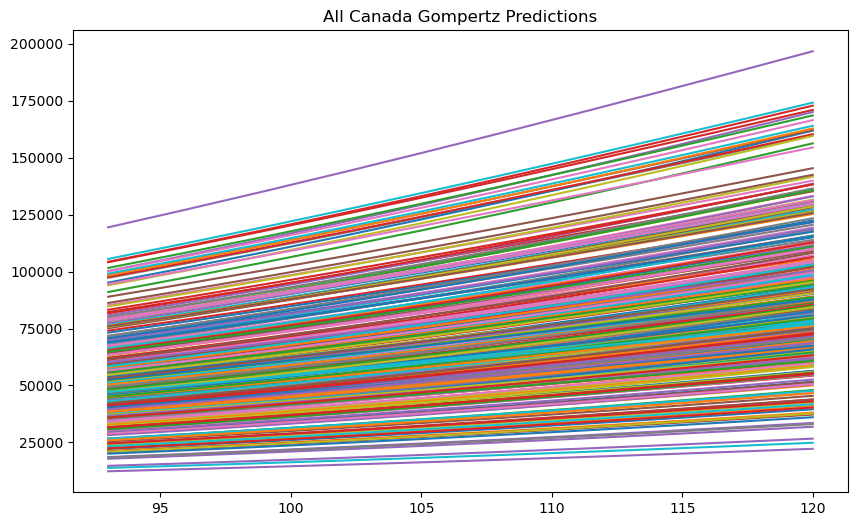

In [60]:
output_all_canada_gomp.plot(legend=False, title='All Canada Gompertz Predictions', figsize=(10, 6))

In [61]:
output_all_canada_gomp_summarized = pd.concat([
    output_all_canada_gomp.max(axis=1).rename('max'),
    output_all_canada_gomp.min(axis=1).rename('min'),
], axis=1)

In [66]:
best_fit_params_gomp = pd.read_csv('..\\results_gomp_all_canada_m_estimated_10_01_26.csv', sep=';')
best_fit_params_gomp

,ZoneID,a,a_se,a_t,b,b_se,b_t,c,c_se,c_t,R2,RMSE
0,NaN,33404362.61,22779015.87,1.466453,0.007465,0.001013,7.37164,8.099479,0.586575,13.808086,0.940491,3169.853219


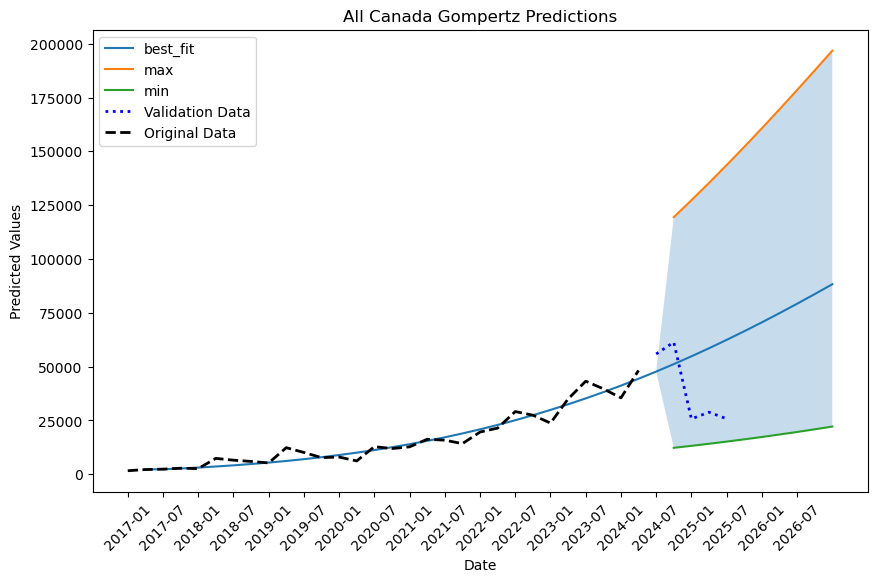

In [71]:
model_gomp = GompertzModel(best_fit_params_gomp['a'][0])
prediction_model_gomp = partial(model_gomp.c_t, b=best_fit_params_gomp['b'][0], c=best_fit_params_gomp['c'][0])
predictions_gomp = time_range_log3.apply(prediction_model_gomp)
predictions_gomp = predictions_gomp.diff().dropna()
predictions_gomp.iloc[0] = predictions_gomp.iloc[1]   # Get rid of weirdly high first value
predictions_gomp.index = time_range_log3.drop(0).reset_index(drop=True)

output_all_canada_gomp_plot = pd.concat([predictions_gomp.rename('best_fit'), output_all_canada_gomp_summarized], axis=1)
output_all_canada_gomp_plot.plot(legend=False, title='All Canada Gompertz Predictions', figsize=(10, 6))

plt.fill_between(
    output_all_canada_gomp_plot.index,
    output_all_canada_gomp_plot.min(axis=1),
    output_all_canada_gomp_plot.max(axis=1),
    alpha=0.25
)

# Plot validation data
plt.plot(
    validation_data['months_since_start'],
    validation_data['VALUE'],
    label='Validation Data',
    color='blue',
    linewidth=2,
    linestyle=':'
)

# Plot original data
plt.plot(original_data_values_log, label='Original Data', color='black', linewidth=2, linestyle='--')
# only tick every 6th month
tick_positions = np.arange(0, len(data_coverage_log), 6)
tick_labels    = data_coverage_log.strftime('%Y-%m')[0::6]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.legend()
# output_all_canada_gomp.to_excel('all_canada_gompertz_predictions_05_01_26.xlsx', index=True)
plt.show()

In [68]:
rmse_gomp = np.sqrt(np.mean((predictions_gomp[:len(original_data_values_log)] - original_data_values_log) ** 2))
rmse_gomp

3169.7191386041413

In [69]:
rmse_val_gomp = np.sqrt(np.mean((predictions_gomp[ len(original_data_values_log): len(original_data_values_log) + len(validation_data)].reset_index(drop=True) - validation_data['VALUE'].reset_index(drop=True)) ** 2))
rmse_val_gomp

28005.832620409197